### import libraries

In [15]:
# %load ../scripts/basic_imports.py
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Modelling Helpers
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from  sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

### load & review dataset

In [16]:
# 
df = pd.read_csv('https://storage.googleapis.com/kagglesdsdata/datasets%2F35901%2F52633%2FwinequalityN.csv?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1592304691&Signature=LZ%2BfPBbs3Ad2FE1SNCVmMGl4FveUm3YJkEm4vkX6w%2F0fiK0RyxJTNr67YkRe61rGDAyHOJRIi0KE49B8SrLbhflERL3wRNc6pATzm3072QoY1o4kLh54mT%2FNum%2BjPdt%2FvHk2W%2BKJL%2FnzvoCj5h4xSA1LtddWikVVYAZS8Mj9KylPAcSVb66h96EzK%2BfyFd5HZOC4EtQ0m3OWYQqAO1ByLUfy0gfH%2BGDiaXReLtti8UXxZNyfywyGEEc6sXW8dZpLJHbZ6SqEcIr26na4CB0qTGinHhCgXOT2H42y%2Bi1uxanqY8dz%2FeGBDqlmM7DxVFE3jnsegF%2F%2FCLR9lMS7aKdjkQ%3D%3D')
df.to_csv('../data/external/wine-quality.csv')

df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Входные переменные (на основе физико-химических тестов):**  
`fixed acidity` - фиксированная кислотность;  
`volatile acidity` - летучая кислотность;  
`citric acid` - лимонная кислота;  
`residual sugar` - остаточный сахар;  
`chlorides` - хлориды;  
`free sulfur dioxide` - свободный диоксид серы;  
`total sulfur dioxide` - общий диоксид серы;  
`density` - плотность;  
`pH` - pH (водородный показатель, где <7 — кислотный раствор, >7 — осн*о*вный);  
`sulphates` - сульфаты;  
`alcohol` - процент содержания алкоголя.  

**Выходная переменная (на основе сенсорных данных):**  
`quality` - оценка качества (от 0 до 10).

In [17]:
# %load ../scripts/review_dataset.py
df.describe().to_csv('../reports/df-describe.csv')
f = open('../reports/df-info.txt', 'w+')
df.info(buf=f)
f.close()

Некоторые наблюдения:  
— верхние квартили признаков `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `sulphates` содержат гораздо большие значения этого показателя, чем первые 75%.

У части признаков есть отсутствующие значения. Заполним их:

In [18]:
# %load ../scripts/fillna.py
na_feature_list = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']

for na_ftr in na_feature_list:
	df[na_ftr] = df[na_ftr].fillna(int(df[na_ftr].median()))

df.to_csv('../data/intermid/df-fillna.csv')

### visualization

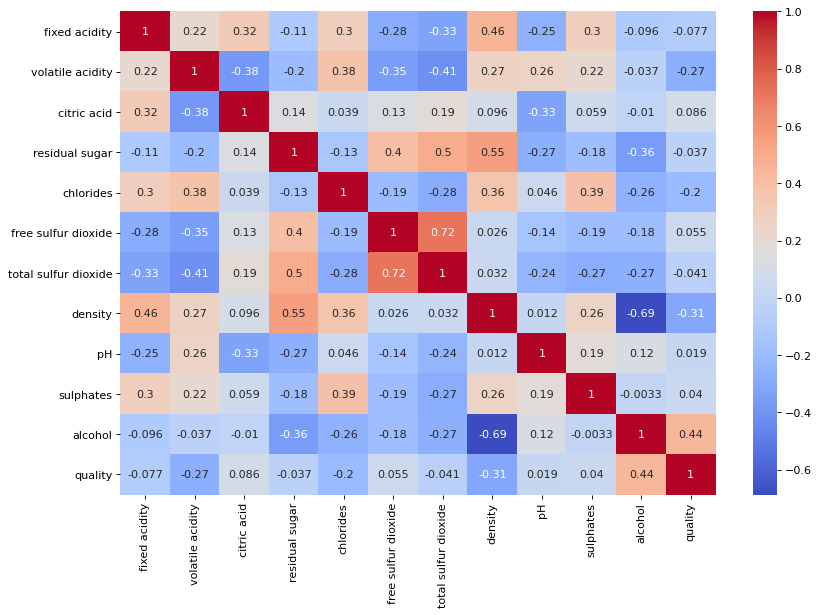

In [19]:
# %load ../scripts/heatmap.py
corr_values = df.iloc[:,1:]
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr_values.corr(), yticklabels=corr_values.columns, cbar=True, cmap='coolwarm', annot=True)
plt.savefig('../reports/heatmap.png')

Можем заметить выделяющиеся зависимости признаков:  
— сильная прямая корелляция `free sulfur dioxide` и `total sulfur dioxide`;   
— сильная обратная корелляция `density` и `alcohol`.

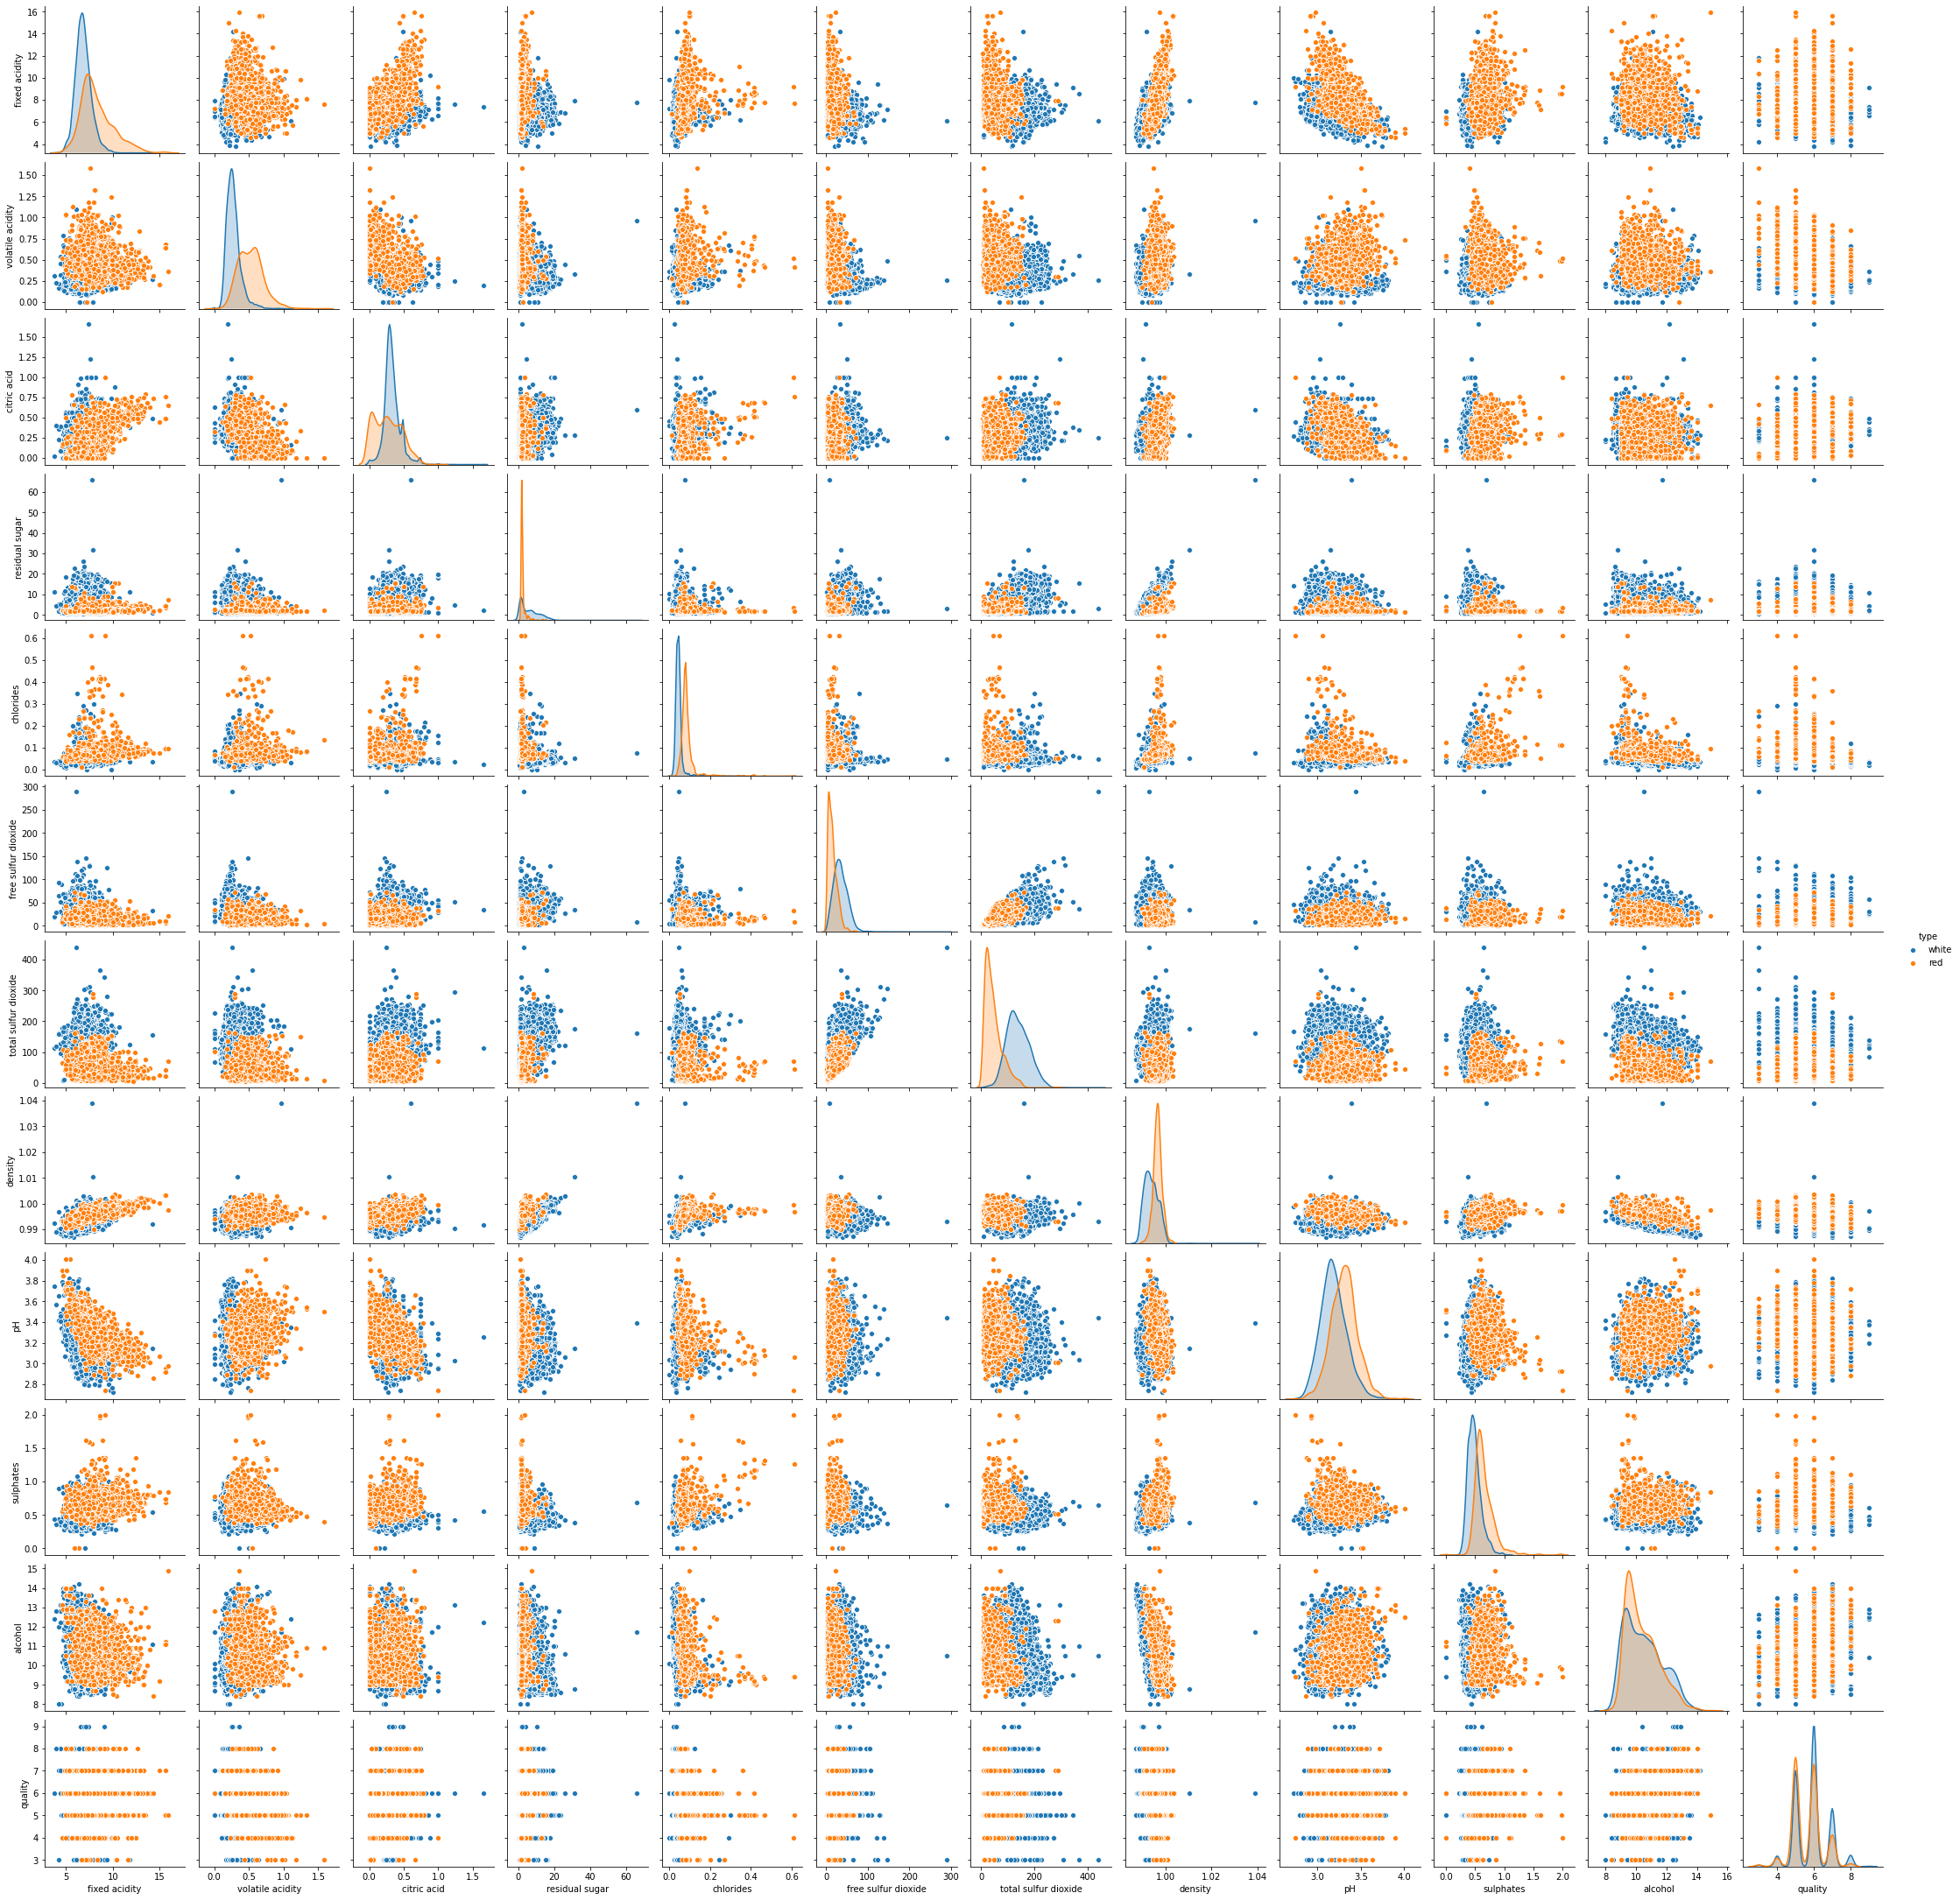

In [20]:
# %load ../scripts/pairplot.py
sns.pairplot(df, hue='type')
plt.savefig('../reports/pairplot.png')

Некоторые наблюдения:  
— линейная зависимость признака `density`;  
— у многих признаков присутствуют выбросы.

### feature engineering

In [21]:
# %load ../scripts/making_data_for_models.py
#add column 'quality_rate'
def quality_rate(x):
	if x['quality'] > 6:
		res = 1
	else:
		res = 0
	return res

df['quality_rate'] = df.apply(quality_rate, axis=1)
df.to_csv('../data/intermid/df-quality-rate.csv')

with open('../data/intermid/description.txt', 'a') as f:
	f.write("— add 'quality_rate' column. Output file: 'df-quality-rate.csv'.\n")
f.close()

#train_test_split
X = df.iloc[:, 1:12]
y = df['quality_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.to_csv('../data/intermid/X_train.csv')
X_test.to_csv('../data/intermid/X_test.csv')
y_train.to_csv('../data/intermid/y_train.csv')
y_test.to_csv('../data/intermid/y_test.csv')

#scaling
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

np.savetxt('../data/intermid/X_train_std.csv', X_train_std)
np.savetxt('../data/intermid/X_test_std.csv', X_test_std)

with open('../data/intermid/description.txt', 'a') as f:
	f.write("— using StandardScaler for X_train and X_test. Output file: 'X_train_std' and 'X_test_std'.\n")
f.close()

### modeling

### logistic regression

In [22]:
# %load ../scripts/logistic_regression.py
param_grid = [{
	'C': np.linspace(0.001,1,10, dtype=float),
	'penalty': ['l1', 'l2'],
	'solver': ['liblinear']
}]

logreg = LogisticRegression(n_jobs=-1)

gs_log = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10)
gs_log = gs_log.fit(X_train_std, y_train)

with open('../models/logistic_regression.pickle', 'wb') as f:
	pickle.dump(gs_log, f)

with open('../reports/models.txt', 'a') as f:
	f.write('Model: {}\n'.format(str(logreg).split('(')[0]))
	f.write('Accuracy: {}\n'.format(gs_log.best_score_))
	f.write('Best params: {}'.format(gs_log.best_params_))
	f.write('\n---\n')
f.close()

### decision tree

In [23]:
# %load ../scripts/decision_tree.py
param_grid = [{
	'max_depth': np.linspace(1,20,5, dtype=int),
	'criterion': ['entropy', 'gini', 'error'],
	'max_leaf_nodes': np.linspace(1,30,10, dtype=int)
}]

tree = DecisionTreeClassifier()

gs_tree = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs_tree = gs_tree.fit(X_train, y_train)

with open('../models/decision_tree.pickle', 'wb') as f:
	pickle.dump(gs_tree, f)

with open('../reports/models.txt', 'a') as f:
	f.write('Model: {}\n'.format(str(tree).split('(')[0]))
	f.write('Accuracy: {}\n'.format(gs_tree.best_score_))
	f.write('Best params: {}'.format(gs_tree.best_params_))
	f.write('\n---\n')
f.close()

### xgboost

In [24]:
# %load ../scripts/xgboost.py
param_grid = {
	'max_depth': np.linspace(1,50,10, dtype=int),
	'n_estimators': np.linspace(1,100,10, dtype=int)
}

xgb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)

gs_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = make_scorer(accuracy_score), cv = 10, refit = 'accuracy_score')
gs_xgb.fit(X_train, y_train)

with open('../models/xgboost.pickle', 'wb') as f:
	pickle.dump(gs_xgb, f)

with open('../reports/models.txt', 'a') as f:
	f.write('Model: {}\n'.format(str(xgb).split('(')[0]))
	f.write('Accuracy: {}\n'.format(gs_xgb.best_score_))
	f.write('Best params: {}'.format(gs_xgb.best_params_))
	f.write('\n---\n')
f.close()

### scoring

In [31]:
# %load ../scripts/scoring_models.py
gs_list = [gs_log, gs_tree, gs_xgb]

for gs in gs_list:
	y_pred = gs.best_estimator_.predict(X_test)
	print(f"Model: {gs}")
	print('Accuracy: %.2f' % accuracy_score(y_true=y_test, y_pred=y_pred))
	print('Precision: %.2f' % precision_score(y_true=y_test, y_pred=y_pred))
	print('Recall: %.2f' % recall_score(y_true=y_test, y_pred=y_pred))
	print('f1_score: %.2f' % f1_score(y_true=y_test, y_pred=y_pred))
	print()

	with open('../reports/score_models.txt', 'a') as f:
		f.write('Model: {}\n'.format(gs))
		f.write('Accuracy: {:.2f}\n'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
		f.write('Precision: {:.2f}\n'.format(precision_score(y_true=y_test, y_pred=y_pred)))
		f.write('Recall: {:.2f}\n'.format(recall_score(y_true=y_test, y_pred=y_pred)))
		f.write('f1_score: {:.2f}\n'.format(f1_score(y_true=y_test, y_pred=y_pred)))
		f.write('---\n')
	f.close()

Model: GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1),
             param_grid=[{'C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             scoring='accuracy')
Accuracy: 0.69
Precision: 0.10
Recall: 0.08
f1_score: 0.09

Model: GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['entropy', 'gini', 'error'],
                          'max_depth': array([ 1,  5, 10, 15, 20]),
                          'max_leaf_nodes': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30])}],
             scoring='accuracy')
Accuracy: 0.84
Precision: 0.66
Recall: 0.32
f1_score: 0.44

Model: GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                             

### deploy

Лучшие оценки получила модель XGBClassifier, поэтому рекомендуем ее к внедрению.

In [26]:
# %load ../scripts/deploying.py
y_pred = gs_xgb.best_estimator_.predict(X_test)
y_pred = pd.DataFrame(y_pred)

y_pred.to_csv('../data/precessed/y_pred.csv')

df['y_pred'] = y_pred
df.to_csv('../data/precessed/wine_prediction_final.csv', index = False )